# A quick demo of `expt`

DISCLAIMER: Many things including API and default behaviors are subject to change.

## 0. Data Preparation Part (can be skipped)

Let's grab some raw log data of training DQN agents that is publicly available:

https://github.com/openai/baselines-results/blob/master/dqn_results.ipynb

In [1]:
# https://github.com/openai/baselines-results/blob/master/dqn_results.ipynb
results_url = "https://openaisciszymon.blob.core.windows.net/dqn-blogpost/results.pkl"
download_path = "dqn_results.pkl"
! [ -e "{download_path}" ] || curl -L {results_url} -o {download_path}

with open(download_path, "rb") as f:
    import pickle
    run_to_episode_data = pickle.load(f)

Let's convert this pickle data into a CSV file, one into each directory.

In [2]:
import pandas as pd
try:
    from tqdm.auto import tqdm
except ImportError:
    tqdm = lambda _: _

def process_data():
    for k in tqdm(sorted(run_to_episode_data.keys())):
        df = pd.DataFrame(run_to_episode_data[k]['episode_data'])
        os.makedirs(f"data/{k}", exist_ok=True)
        df.to_csv(f"data/{k}/progress.csv", index=False)

    print(f"Total number of directories = {len(run_to_episode_data)}")

if not os.path.isdir("data/"):
    process_data()

In [3]:
!ls data/ | head -n6

atari-a-alien-123
atari-a-alien-456
atari-a-alien-789
atari-a-amidar-123
atari-a-amidar-456
atari-a-amidar-789


## 1. Setup

In [4]:
%load_ext autoreload
%aimport expt.data
%aimport expt.plot
%autoreload 1
from importlib import reload

In [5]:
%matplotlib inline
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

from PIL import Image
from IPython.core.pylabtools import figsize

mpl.rcParams['pdf.fonttype'] = 42     # use true-type
mpl.rcParams['ps.fonttype'] = 42      # use true-type
mpl.rcParams['font.size'] = 12

%config InlineBackend.figure_format = 'retina'

In [6]:
import expt
print("expt:", expt.__version__)

import pandas as pd
import numpy as np

expt: 0.4.0.dev0


## 2. Data Loading

The `expt.get_runs` function parses training directories in parallel, giving a sequence of `Run` objects. A `Run` instance contains a pandas DataFrame, usually corresponding to one single job and single directory.

`expt.get_runs` can parse a directory that contains CSV files (e.g. `progress.csv`) or tensorboard event files.

In [7]:
expt.get_runs?

Signature:
expt.get_runs(
    *path_globs,
    verbose=False,
    n_jobs=8,
    fillna=True,
    pool_class=<class 'multiprocess.pool.Pool'>,
    progress_bar=True,
    run_postprocess_fn=None,
) -> expt.data.RunList
Docstring:
Get a list of Run objects from the given path glob patterns.

This runs in parallel, using the multiprocess library (a fork of python
standard library multiprocessing) which is more friendly with ipython
and serializing non-picklable objects.
File:      ~/workspace/dev/expt/expt/data_loader.py
Type:      function


In [8]:
run = expt.get_runs("./data/atari-prior-duel-a-alien-*")
run[0]

  0%|          | 0/1 [00:00<?, ?it/s]

Run('./data/atari-prior-duel-a-alien-123', DataFrame with 40799 rows)

In [9]:
# You can see that a `Run` is basically a wrapper of pandas DataFrame,
# storing time-series data for several columns (metrics):
run[0].df

,initial_reset_time,episode_rewards,episode_lengths,episode_end_times
0,0,190.0,2879,4.581740
1,0,250.0,2395,7.680398
2,0,180.0,3411,11.984523
3,0,140.0,2615,15.358311
4,0,240.0,2755,18.986382
...,...,...,...,...
40794,0,4080.0,6790,682605.500080
40795,0,3210.0,5676,682623.048560
40796,0,1020.0,4055,682635.724665
40797,0,2630.0,6202,682655.405495


Now let's plot and look at one `Run` consisting of four columns (see `Run.plot()`)

Here, `rolling=100` means we use a window size of 100 for smoothing the curve (running average).

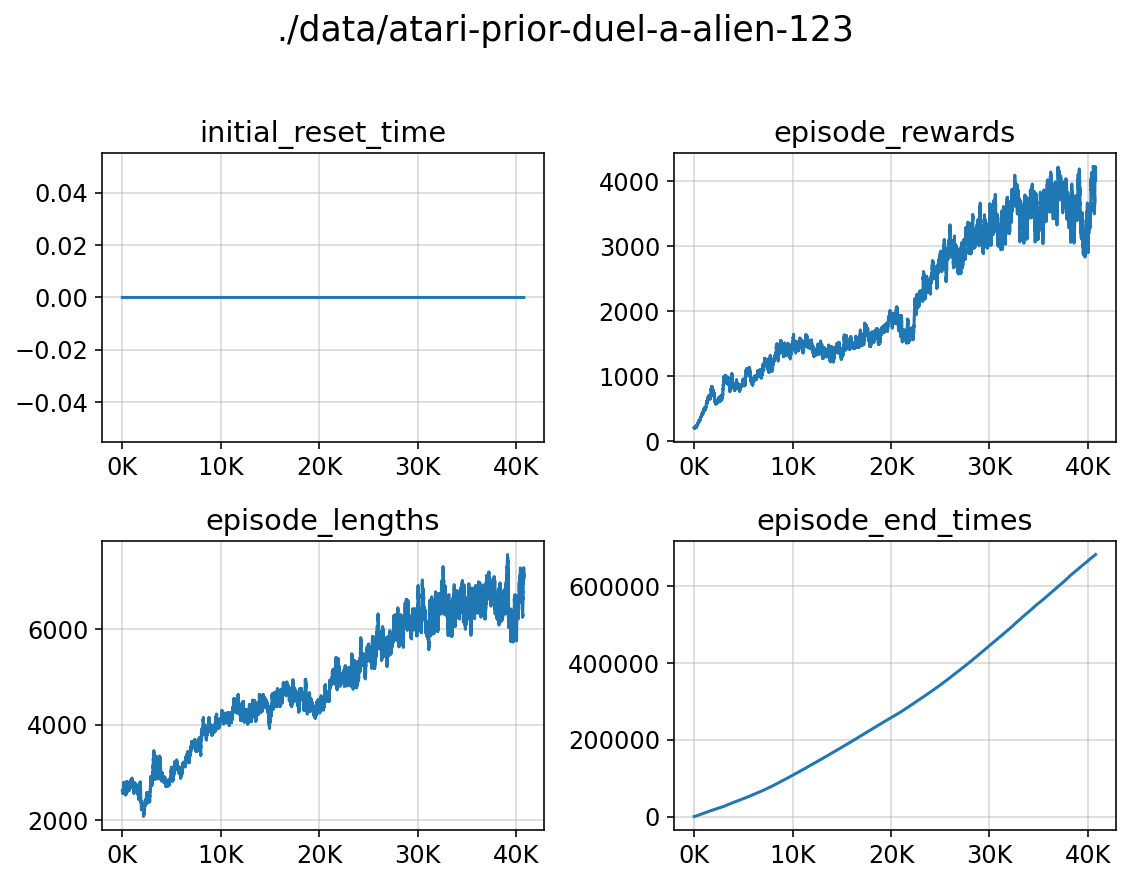

In [10]:
run[0].plot(rolling=100);

## 3. Three Main Data Structures: Run, Hypothesis, Experiment

The following are the fundamental data types in `expt`:
    
- `Run`: A single run that holds a time-series DataFrame. This is usually corresponds to a single experiment run (i.e., a single log_dir as `path`).
- `Hypothesis`: A group of runs that can be averaged as a **single entry** (e.g., a variant of algorithm with random seeds)
  - Typically, one hypothesis consists of one more more runs with same hyperparameter config but different random seeds.
- `Experiment`: A group or collection of `Hypothesis`'s to be compared with one another.

In the following example, where we have four `Hypotheses` (i) DQN (ii) Double DQN (iii) DQN + PER (iv) Double DQN + PER,
each of which constis of three `Run`s.

Let's create `Experiment` and `Hypothesis` objects for this experiment, a little bit manually (Note: in Section 5, we will discuss how else we can construct the data structures):

In [11]:
ex = expt.Experiment("Comparison of DQN Variants")
env = 'amidar'

def make_total_timesteps(r: expt.Run) -> expt.Run:
    """A post-processing after parsing the run: Add a new column 'total_timesteps'.

    Note that in this example, the raw CSV logging data did not include global step (total_timesteps).
    So we take a cumulative sum of episode lengths, which can be the x-axis (total environment steps) for all plots below.
    """

    # This should be our x-axis. Note that this might be not aligned across different runs
    r.df['total_timesteps'] = r.df['episode_lengths'].cumsum()
    return r

for algo, desc in {"a": "DQN",
                   "duel-a": "Double DQN",
                   "prior-a": "DQN + PER",
                   "prior-duel-a": "Double DQN + PER",
                  }.items():
    runs = expt.get_runs(f"./data/atari-{algo}-{env}-*", progress_bar=None,
                         run_postprocess_fn=make_total_timesteps)

    # h = runs.to_hypothesis(name=desc)
    # ex.add_hypothesis(desc, h)
    ex.add_runs(desc, runs=runs)

In [12]:
# Summarize the data: by default, the average over last 10% rows are reported.
ex.summary()

,name,index,initial_reset_time,episode_lengths,episode_rewards,episode_end_times,total_timesteps
0,DQN,30707,0.0,7324.683550,784.491205,505011.109550,1.920179e+08
1,Double DQN,29188,0.0,8370.229724,1064.562371,609950.799399,1.902990e+08
2,DQN + PER,23912,0.0,12108.668061,1620.768716,555125.618996,1.876133e+08
3,Double DQN + PER,21613,0.0,14784.331328,2192.625405,622450.219563,1.883250e+08


In [13]:
ex.columns

['initial_reset_time',
 'episode_lengths',
 'episode_rewards',
 'episode_end_times',
 'total_timesteps']

## 4. Plotting using Data API

Now let's walk through how we can draw some plots from the `Hypothesis`, `Experiment` instances.

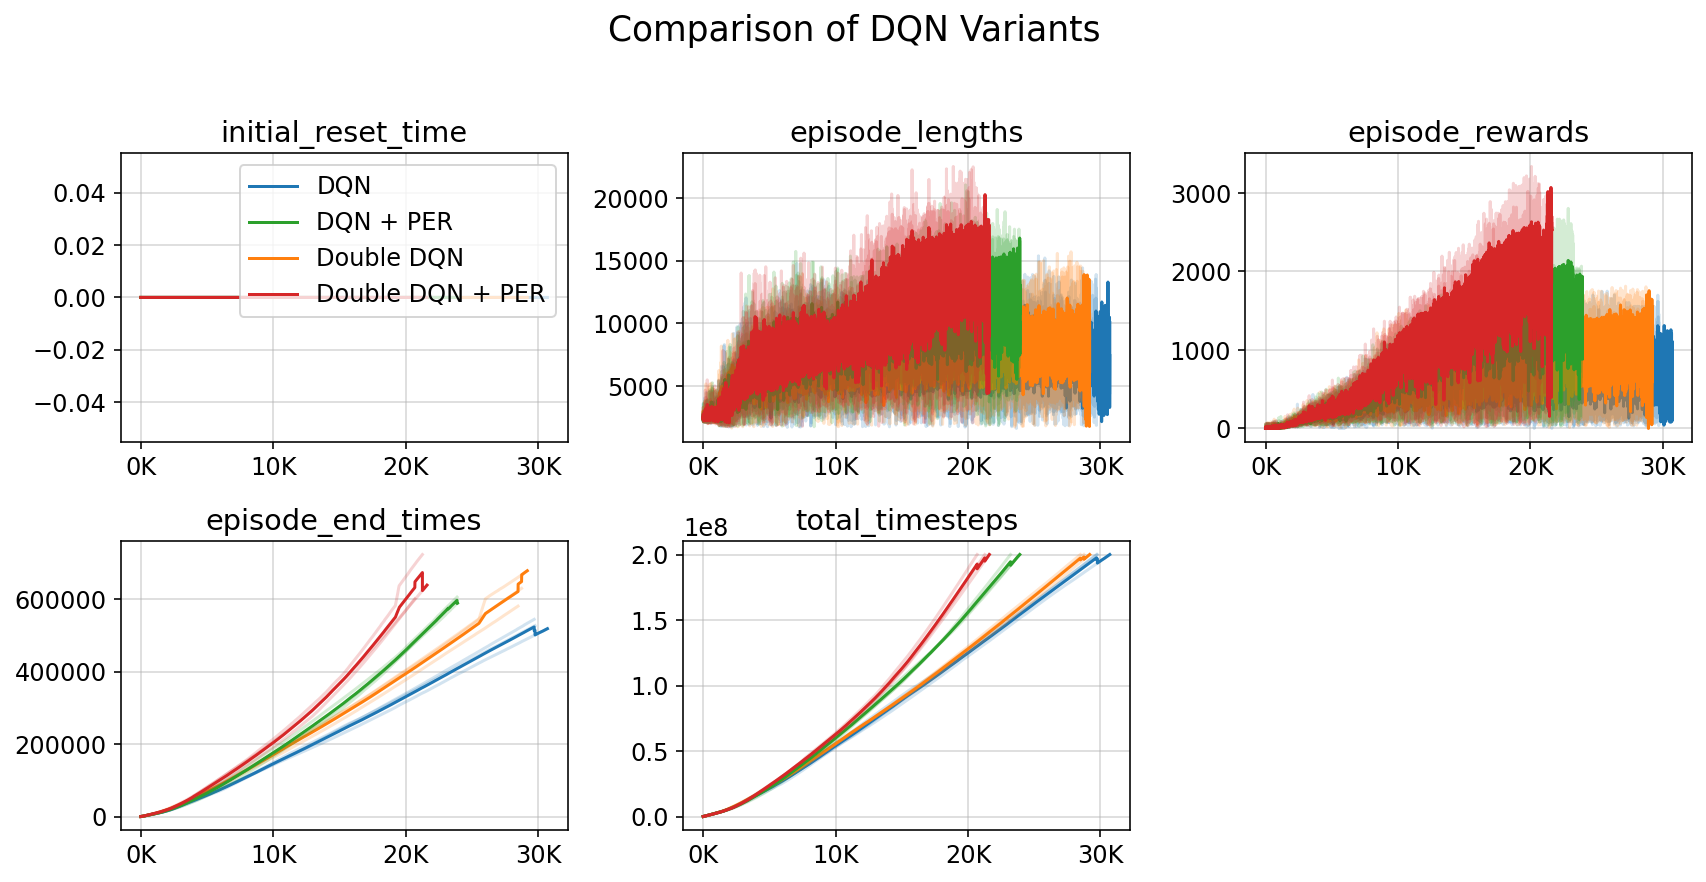

In [14]:
g = ex.plot()

Simply calling `Experiment.plot()` or `Hypothesis.plot()` will give you a reasonable plot like this.

This default one doesn't look quite good; however, it should be much better than the default behavior of `DataFrame.plot()`. Note that the x-axis is the index of the DataFrames (i.e., rows in the table).

We can pass sensible arguments from `DataFrame.plot()`, such as `x=...`, `y=...`, `figsize=...`, etc. Other useful ones are `rolling` and `n_samples`, which will give you better appearance and faster plotting by sub-sampling and interpolating the data (it is also useful when dealing with a x-axis that is not aligned across different random seeds).

With these, here is how we can do better:

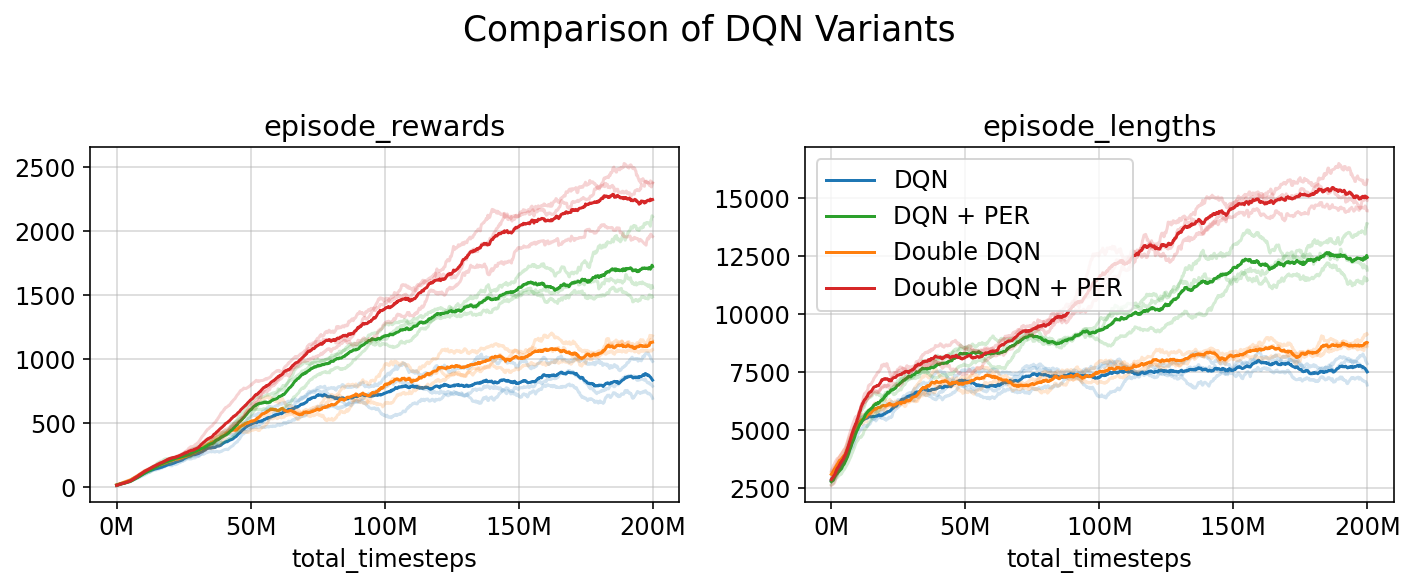

In [15]:
g = ex.plot(x='total_timesteps', y=['episode_rewards', 'episode_lengths'],
            rolling=50, n_samples=1000, legend='episode_lengths', figsize=(10, 4))

Nice! Actually we can access interpolated `Experiment` and `Hypothesis` objects:

In [16]:
h: expt.Hypothesis = ex["DQN"]
h.interpolate('total_timesteps', n_samples=1000)

Hypothesis('DQN', 3 runs: [
 Run('./data/atari-a-amidar-123', DataFrame with 1000 rows),
 Run('./data/atari-a-amidar-456', DataFrame with 1000 rows),
 Run('./data/atari-a-amidar-789', DataFrame with 1000 rows),
])

Here is an example of how you can do more general manipulation of DataFrames **before** plotting: such as different way of smoothing (e.g., exponential averaging rather than `rolling` window) and subsampling/interpolation:

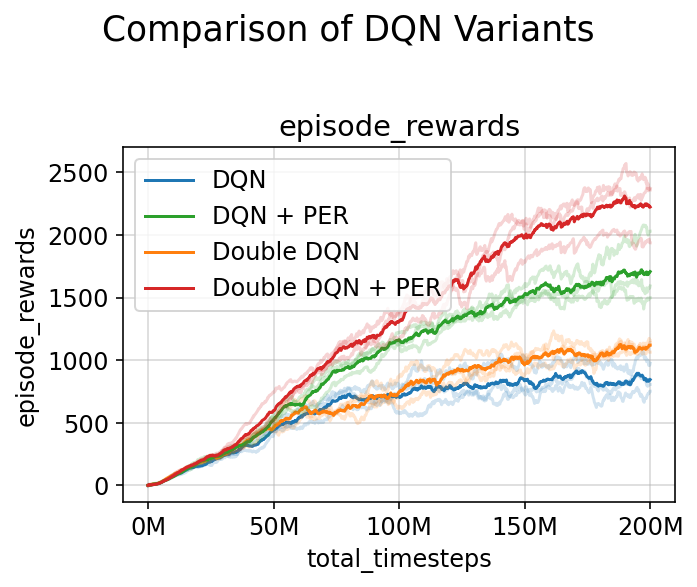

In [17]:
(ex
 .interpolate('total_timesteps', n_samples=1000)
 .apply(lambda df: df.ewm(alpha=0.05).mean())  # Use exponential averaging, x_t = 0.95 * x_{t-1} + 0.05 * a_t
).plot(y='episode_rewards', figsize=(5, 4));

### Tweaking How to Show Individual Runs

By default, each individual run (e.g., different random seeds) will be shown (`err_style="runs"`, see also `runs_alpha`).

If you would like to draw 1-std confidence interval instead, try `err_style="fill"` (see also `std_alpha`):

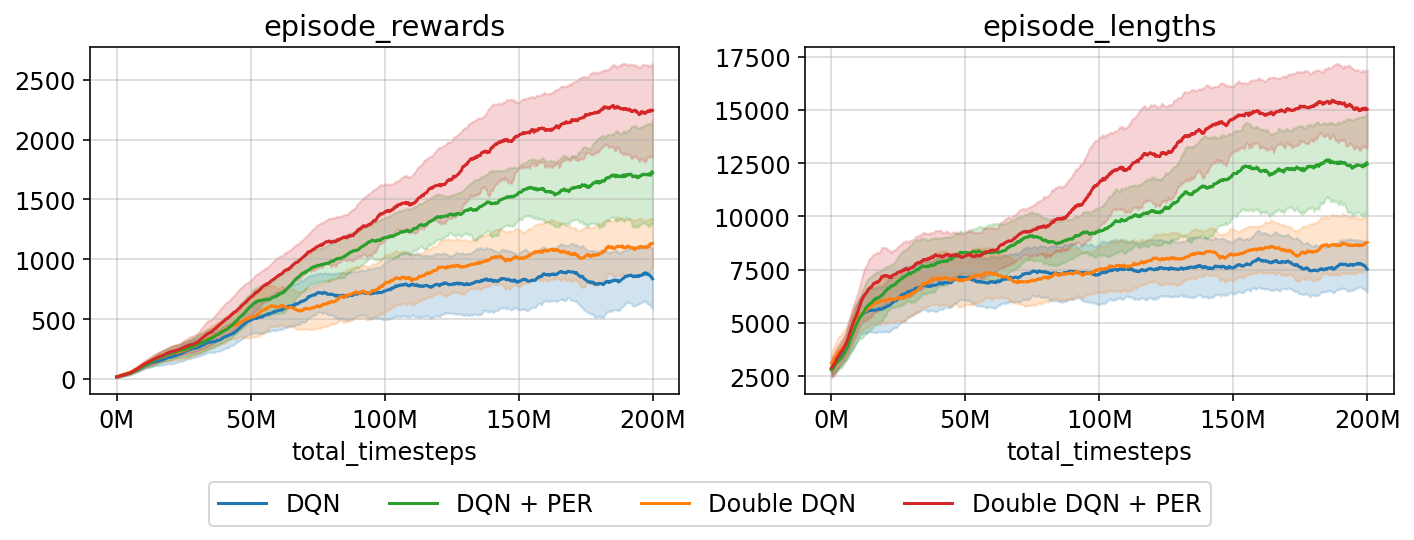

In [18]:
g = ex.plot(x='total_timesteps', y=['episode_rewards', 'episode_lengths'],
            rolling=50, n_samples=1000, err_style="fill",
            legend=False, suptitle="", figsize=(10, 4))

# Optional: add a legend on the figure. The lower center of the legend box should be at (x=0.5, y=0.0)
# To avoid cropping, we should adjust the figure height and subplot regions accoridingly.
# see https://matplotlib.org/3.2.1/api/legend_api.html#matplotlib.legend.Legend
g.add_legend(ax=None, loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=4);
g.figure.subplots_adjust(bottom=0.25)

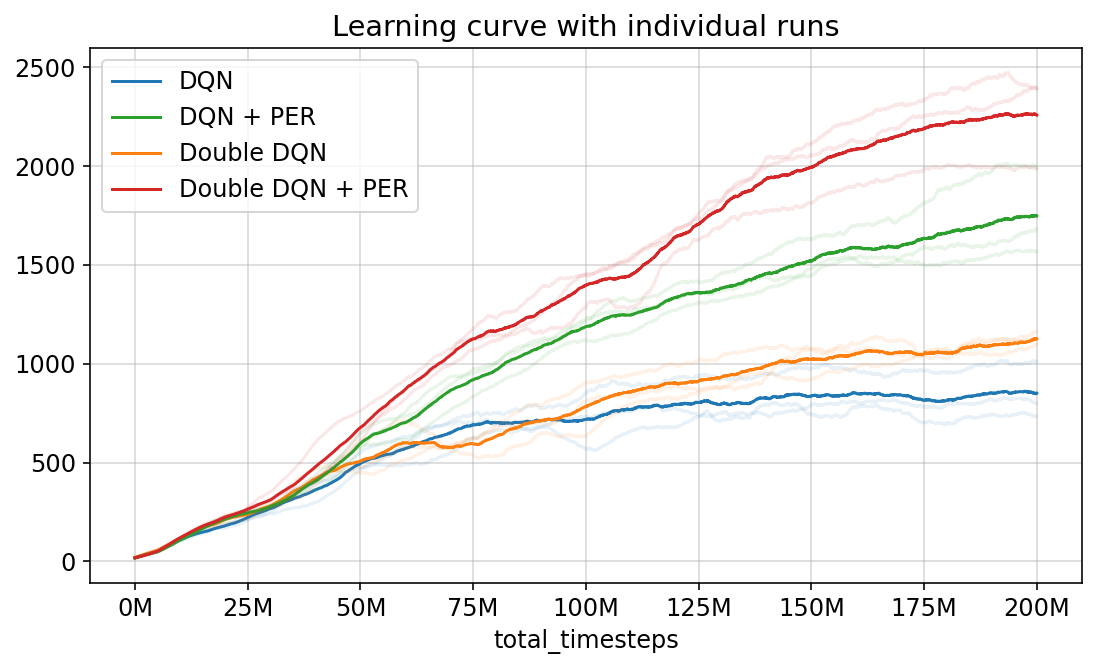

In [19]:
# Draw on existing matplotlib Figure or Axes
fig, ax = plt.subplots(figsize=(8, 5))

ex.plot(x='total_timesteps', y='episode_rewards',
        rolling=500, n_samples=10000,
        err_style='runs', runs_alpha=0.1, 
        suptitle="", ax=ax);

# further customization using matplotlib API
ax.set_title("Learning curve with individual runs")
ax.yaxis.set_label_text("")
fig;

### More manual control

Finally, it is also possible to plot individual `Hypothesis` and Run objects, in case you would want more fine-grained, manual plotting:

Hypothesis('DQN', 3 runs: [
 Run('./data/atari-a-amidar-123', DataFrame with 29774 rows),
 Run('./data/atari-a-amidar-456', DataFrame with 29711 rows),
 Run('./data/atari-a-amidar-789', DataFrame with 30708 rows),
])
Hypothesis('Double DQN', 3 runs: [
 Run('./data/atari-duel-a-amidar-123', DataFrame with 28758 rows),
 Run('./data/atari-duel-a-amidar-456', DataFrame with 28491 rows),
 Run('./data/atari-duel-a-amidar-789', DataFrame with 29189 rows),
])


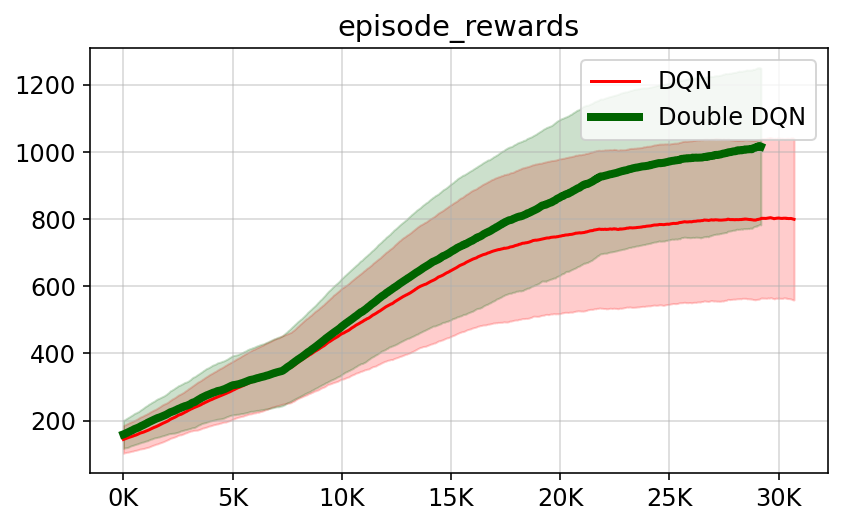

In [20]:
fig, ax = plt.subplots()
fig.suptitle("DQN vs Double DQN")

h = ex.hypotheses[0]
print(h)
h.plot(rolling=500, n_samples=1000, y='episode_rewards', err_style='band',
       color='red', suptitle="", legend=True, ax=ax);

h = ex.hypotheses[1]
print(h)
h.plot(rolling=500, n_samples=1000, y='episode_rewards', err_style='band',
       color='darkgreen', suptitle="", legend=True, linewidth=4.0, ax=ax);

## 5. More plotting examples

As seen previously, `Experiment` is just a simple collection of `Hypothesis` objects. However, it might be a little inconvenient to create a bunch of `Hypothesis` instance (see Section 3 for example) rather manually if there are many different runs and data to analyze.

In this example, we will see how runs and hypothesis can be automatically grouped, organized and queried.

### 5.1. Grouping raw runs into multiple Hypotheses

Let's first collect all the runs (255 in total for this example).

In [21]:
runs = expt.get_runs("./data/atari-*").filter(lambda r: 'rb' not in r.name)

# Pre-processing runs
for r in runs:
    r.df['total_timesteps'] = r.df['episode_lengths'].cumsum()

print("Length:", len(runs))
print("Sample:", runs[0])
print("Columns:", list(runs[0].df.columns))

  0%|          | 0/1 [00:00<?, ?it/s]

Length: 228
Sample: Run('./data/atari-a-alien-123', DataFrame with 50219 rows)
Columns: ['initial_reset_time', 'episode_rewards', 'episode_lengths', 'episode_end_times', 'total_timesteps']


Now we will need to **group** runs by a column (`algorithm`) (i.e., different hypothesis), `environment` (or dataset), aggregating over different random seeds.

`RunList.to_dataframe` and `Experiment.from_dataframe` are very useful APIs for this purpose. Think of the dataframe as some kind of "Pivot Tables", grouped by different configurations (hyperparameters), i.e., different hypotheses.

In [22]:
from typing import Dict, Any

algorithm_name = {'a': 'DQN',
                  'duel-a': 'Double DQN',
                  'prior-a': 'DQN + PER',
                  'prior-duel-a': 'Double DQN + PER'}

def run_config(run) -> Dict[str, Any]:
    # This is a contrived example of parsing the name(path) of Run into a config dict.
    # In practice, the config dict can be obtained form r.config (the default behavior)
    m = re.match("atari-(?P<algorithm>a|duel-a|prior-a|prior-duel-a)?-(?P<env_id>[a-z]+)-(?P<seed>[0-9]+)", run.name)
    params = m.groupdict()   # {algorithm: ..., env_id: ..., seed: ...}
    params['algorithm'] = algorithm_name[params['algorithm']]
    return params

rt = runs.to_dataframe(config_fn=run_config)
rt

seed                              name  \
algorithm        env_id                                             
DQN              alien      123                 atari-a-alien-123   
                 alien      456                 atari-a-alien-456   
                 alien      789                 atari-a-alien-789   
                 amidar     123                atari-a-amidar-123   
                 amidar     456                atari-a-amidar-456   
...                         ...                               ...   
Double DQN + PER timepilot  456  atari-prior-duel-a-timepilot-456   
                 timepilot  789  atari-prior-duel-a-timepilot-789   
                 upndown    123    atari-prior-duel-a-upndown-123   
                 upndown    456    atari-prior-duel-a-upndown-456   
                 upndown    789    atari-prior-duel-a-upndown-789   

                                                                          run  
algorithm        env_id                                                        
DQN              alien      Run('./data/atari-a-alien-123', DataFrame with...  
                 alien      Run('./data/atari-a-alien-456', DataFrame with...  
                 alien      Run('./data/atari-a-alien-789', DataFrame with...  
                 amidar     Run('./data/atari-a-amidar-123', DataFrame wit...  
                 amidar     Run('./data/atari-a-amidar-456', DataFrame wit...  
...                                                                       ...  
Double DQN + PER timepilot  Run('./data/atari-prior-duel-a-timepilot-456',...  
                 timepilot  Run('./data/atari-prior-duel-a-timepilot-789',...  
                 upndown    Run('./data/atari-prior-duel-a-upndown-123', D...  
                 upndown    Run('./data/atari-prior-duel-a-upndown-456', D...  
                 upndown    Run('./data/atari-prior-duel-a-upndown-789', D...  

[228 rows x 3 columns]

It is also possible to aggregate over random seeds and automatically combine the runs into a `Hypothesis` (per different configuration):

In [23]:
rt = runs.to_dataframe(config_fn=run_config,
                       as_hypothesis=True, hypothesis_namer=lambda cfg, _: cfg['algorithm'])
rt

hypothesis
algorithm        env_id                                                       
DQN              alien       Hypothesis('DQN', 3 runs: [
 Run('./data/atari...
                 amidar      Hypothesis('DQN', 3 runs: [
 Run('./data/atari...
                 bankheist   Hypothesis('DQN', 3 runs: [
 Run('./data/atari...
                 beamrider   Hypothesis('DQN', 3 runs: [
 Run('./data/atari...
                 boxing      Hypothesis('DQN', 3 runs: [
 Run('./data/atari...
...                                                                        ...
Double DQN + PER riverraid   Hypothesis('Double DQN + PER', 3 runs: [
 Run(...
                 roadrunner  Hypothesis('Double DQN + PER', 3 runs: [
 Run(...
                 robotank    Hypothesis('Double DQN + PER', 3 runs: [
 Run(...
                 timepilot   Hypothesis('Double DQN + PER', 3 runs: [
 Run(...
                 upndown     Hypothesis('Double DQN + PER', 3 runs: [
 Run(...

[76 rows x 1 columns]

Now let's draw a grid of plots to compare the four algorithms (Hypothesis), for each of the 19 environment/domains:

  0%|          | 0/19 [00:00<?, ?it/s]

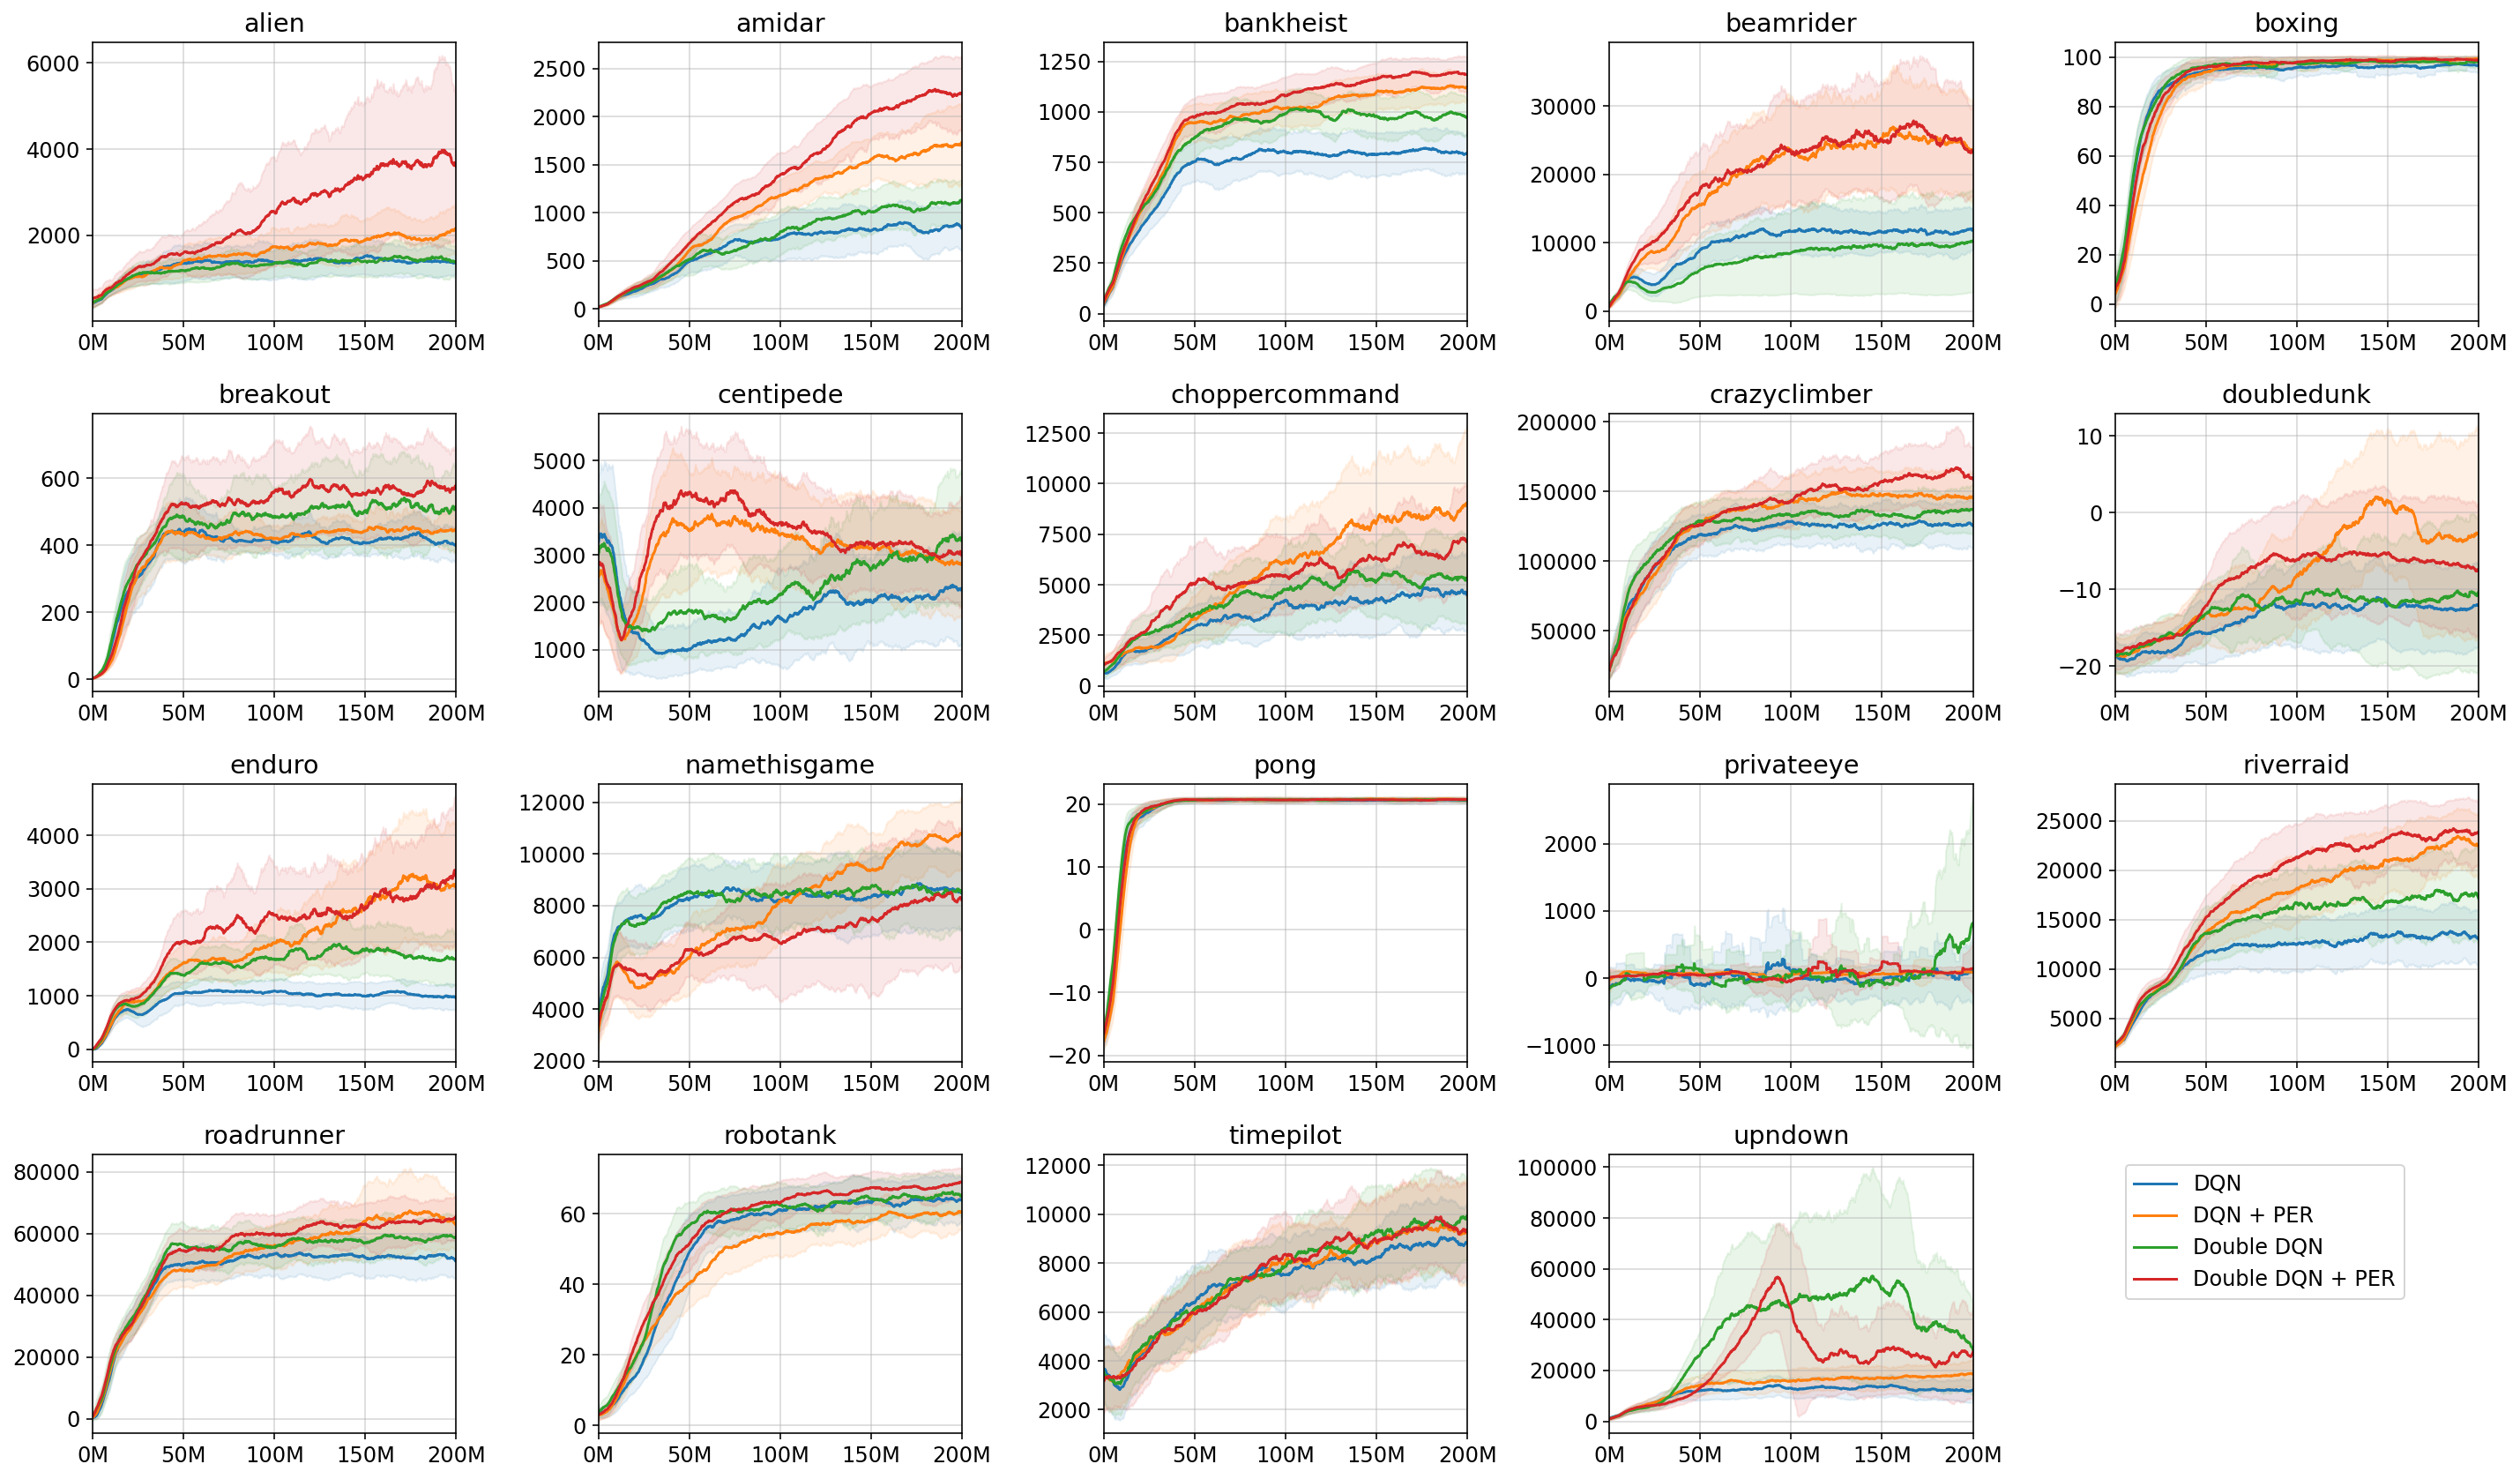

In [24]:
from tqdm.auto import tqdm
from expt.plot import GridPlot

g = GridPlot(y_names=rt.reset_index().env_id.unique())

for env_id, t in tqdm(rt.groupby('env_id')):
    # Or you can do something like rt.query('env_id == ....')

    ex = expt.Experiment.from_dataframe(t, name=env_id)
    ex.plot(ax=g[env_id], title=env_id,
            x='total_timesteps', y='episode_rewards',
            err_style='band', std_alpha=0.1,
            rolling=50, n_samples=1000, legend=False,
            tight_layout=False,
           )

# Put a legend on the last empty grid axes
g.add_legend(ax=g.axes[-1, -1], loc="upper left", bbox_to_anchor=(0, 1))

# Some post-processing with matplotlib API so that the plot looks nicer
for ax in g.axes_active:
    ax.xaxis.set_label_text("")
    ax.yaxis.set_label_text("")
    ax.set_xlim(0, 200e6)

g.fig.tight_layout(h_pad=1.3, w_pad=1.0)
g.fig;

It is also worth noting that passing `include_summary=True` will make the DataFrame have additional columns representing the summary statistics for each `Hypothesis`.

In [25]:
rt = runs.to_dataframe(config_fn=run_config, as_hypothesis=True, include_summary=True)
rt.query('env_id == "robotank"')

,,hypothesis,index,initial_reset_time,episode_rewards,episode_lengths,episode_end_times,total_timesteps
algorithm,env_id,,,,,,,
DQN,robotank,"Hypothesis('algorithm=DQN; env_id=robotank', 3...",9039,0.0,63.192662,26879.050147,490972.679158,1.919944e+08
DQN + PER,robotank,Hypothesis('algorithm=DQN + PER; env_id=robota...,8273,0.0,59.290206,28096.496775,546606.613487,1.909207e+08
Double DQN,robotank,Hypothesis('algorithm=Double DQN; env_id=robot...,8732,0.0,64.632493,26378.774532,581132.635157,1.896889e+08
Double DQN + PER,robotank,Hypothesis('algorithm=Double DQN + PER; env_id...,8584,0.0,67.372378,26409.699301,688746.857710,1.898476e+08
